In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os

In [8]:
def read_csv_to_pkl_and_rename(path, class_name):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)

        # Ensure it's a file and not a directory
        if os.path.isfile(file_path):
            if file.endswith(".csv"):
                # Read the CSV file
                data = pd.read_csv(file_path)

                # Determine the suffix based on the file name
                if "Accelerometer" in file:
                    suffix = "_acc"
                elif "Gyroscope" in file:
                    suffix = "_gyro"
                else:
                    continue  # Skip files that are neither Accelerometer nor Gyroscope

                # Create new filenames with the suffix
                new_base_name = f"{class_name}{suffix}"
                pkl_file_path = os.path.join(path, f"{new_base_name}.pkl")
                new_csv_file_path = os.path.join(path, f"{new_base_name}.csv")

                # Save the data as a pickle file
                data.to_pickle(pkl_file_path)

                # Rename the CSV file
                os.rename(file_path, new_csv_file_path)

                print(
                    f"Converted {file} to {new_base_name}.pkl and renamed CSV to {new_base_name}.csv"
                )


# Example usage
# read_csv_to_pkl_and_rename("newdata/", "data")
# Example usage

In [9]:
def combine_pickles_with_class(path, class_name):
    # Initialize lists to hold acc and gyro files
    acc_files = []
    gyro_files = []

    # List all files in the directory
    for file in os.listdir(path):
        if file.startswith(class_name) and file.endswith("_acc.pkl"):
            acc_files.append(file)
        elif file.startswith(class_name) and file.endswith("_gyro.pkl"):
            gyro_files.append(file)

    # Create a list to hold the combined data for all the files
    combined_data_list = []

    # Rename columns appropriately for acc and gyro DataFrames
    for i in range(len(acc_files)):
        acc_df = pd.read_pickle(path + acc_files[i])
        gyro_df = pd.read_pickle(path + gyro_files[i])

        # Drop the first column (assumed to be an index or unneeded)

        # if num of columns is 4, then drop the first column
        if len(acc_df.columns) == 4:
            acc_df.drop(acc_df.columns[0], axis=1, inplace=True)
            gyro_df.drop(gyro_df.columns[0], axis=1, inplace=True)

        # Rename columns
        acc_df.columns = ["ax", "ay", "az"]
        gyro_df.columns = ["gx", "gy", "gz"]

        # Combine acc and gyro DataFrames horizontally
        combined_df = pd.concat([acc_df, gyro_df], axis=1)

        # # Add class column
        # combined_df["class"] = class_name

        # # Append the combined DataFrame to the list
        combined_data_list.append(combined_df)

    # Concatenate all DataFrames vertically to get the final combined DataFrame
    final_df = pd.concat(combined_data_list, ignore_index=True)

    return final_df


# test the function
new_data = combine_pickles_with_class("newdata/", "data")

In [14]:
new_data.head()
X_new = new_data[
    ["ax", "ay", "az", "gx", "gy", "gz"]
]  # Adjust column names accordingly

X_new.shape

(7981, 6)

In [16]:
# Select the relevant features (adjust column names as needed)
X_new = new_data[["ax", "ay", "az", "gx", "gy", "gz"]]

# Standardize the new data using the same scaler used during training
scaler = StandardScaler()  # Use the scaler from your training phase if available
X_new = scaler.fit_transform(X_new)

# Get the number of samples and features
num_samples = X_new.shape[0]
num_features = X_new.shape[1]  # This should be 6 (ax, ay, az, gx, gy, gz)

# Define the window length
window_length = 60  # Example window length (in timesteps)

# Trim the data so that the number of samples is divisible by the window length
trimmed_num_samples = (num_samples // window_length) * window_length
X_new_trimmed = X_new[:trimmed_num_samples]  # Trim the data

# Reshape the trimmed data for RNN (e.g., (num_windows, window_length, num_features))
X_new_reshaped = X_new_trimmed.reshape(-1, window_length, num_features)

# Check the new shape after trimming and reshaping
print("New reshaped data shape:", X_new_reshaped.shape)

# Load the trained model
model = load_model("model.h5")

# Make predictions on the reshaped data
predicted_classes = model.predict(X_new_reshaped)
predicted_classes = np.argmax(
    predicted_classes, axis=1
)  # Convert probabilities to class indices

# Print the predicted classes
print("Predicted Classes for New Data:", predicted_classes)

# Optional: Visualize the raw data and predicted classes using Matplotlib
plt.figure(figsize=(10, 6))

# Plot acceleration data (for example)
plt.subplot(2, 1, 1)
plt.plot(new_data[["ax", "ay", "az"]])
plt.title("Acceleration Data")
plt.xlabel("Time")
plt.ylabel("Acceleration")
for i, pred_class in enumerate(predicted_classes):
    plt.axvline(
        x=i * window_length, color="r", linestyle="--", label=f"Class {pred_class}"
    )

# Plot gyro data (for example)
plt.subplot(2, 1, 2)
plt.plot(new_data[["gx", "gy", "gz"]])
plt.title("Gyro Data")
plt.xlabel("Time")
plt.ylabel("Gyroscope")
for i, pred_class in enumerate(predicted_classes):
    plt.axvline(
        x=i * window_length, color="r", linestyle="--", label=f"Class {pred_class}"
    )

plt.tight_layout()
plt.show()

New reshaped data shape: (133, 60, 6)


ValueError: in user code:

    File "/Users/ahmedabd/miniconda3/envs/my_jupyter_env/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Users/ahmedabd/miniconda3/envs/my_jupyter_env/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ahmedabd/miniconda3/envs/my_jupyter_env/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/ahmedabd/miniconda3/envs/my_jupyter_env/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Users/ahmedabd/miniconda3/envs/my_jupyter_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/ahmedabd/miniconda3/envs/my_jupyter_env/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 6, 1), found shape=(None, 60, 6)


New reshaped data shape: (7981, 6, 1)
250/250 [==============================] - 2s 4ms/step
Predicted Classes for New Data: [0 3 3 ... 3 3 3]


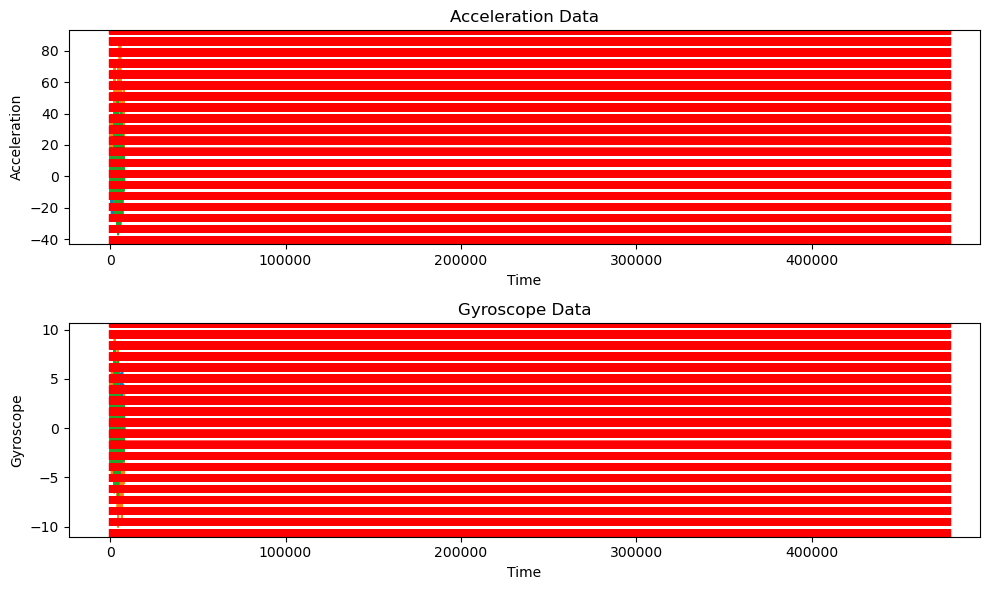

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os


# Function to convert CSV to pickle and rename
def read_csv_to_pkl_and_rename(path, class_name):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)

        # Ensure it's a file and not a directory
        if os.path.isfile(file_path):
            if file.endswith(".csv"):
                # Read the CSV file
                data = pd.read_csv(file_path)

                # Determine the suffix based on the file name
                if "Accelerometer" in file:
                    suffix = "_acc"
                elif "Gyroscope" in file:
                    suffix = "_gyro"
                else:
                    continue  # Skip files that are neither Accelerometer nor Gyroscope

                # Create new filenames with the suffix
                new_base_name = f"{class_name}{suffix}"
                pkl_file_path = os.path.join(path, f"{new_base_name}.pkl")
                new_csv_file_path = os.path.join(path, f"{new_base_name}.csv")

                # Save the data as a pickle file
                data.to_pickle(pkl_file_path)

                # Rename the CSV file
                os.rename(file_path, new_csv_file_path)

                print(
                    f"Converted {file} to {new_base_name}.pkl and renamed CSV to {new_base_name}.csv"
                )


# Function to combine accelerometer and gyroscope data
def combine_pickles_with_class(path, class_name):
    acc_files = []
    gyro_files = []

    # List all files in the directory
    for file in os.listdir(path):
        if file.startswith(class_name) and file.endswith("_acc.pkl"):
            acc_files.append(file)
        elif file.startswith(class_name) and file.endswith("_gyro.pkl"):
            gyro_files.append(file)

    combined_data_list = []

    # Rename columns appropriately for acc and gyro DataFrames
    for i in range(len(acc_files)):
        acc_df = pd.read_pickle(os.path.join(path, acc_files[i]))
        gyro_df = pd.read_pickle(os.path.join(path, gyro_files[i]))

        # Drop unnecessary columns if present
        if len(acc_df.columns) == 4:
            acc_df.drop(acc_df.columns[0], axis=1, inplace=True)
            gyro_df.drop(gyro_df.columns[0], axis=1, inplace=True)

        # Rename columns
        acc_df.columns = ["ax", "ay", "az"]
        gyro_df.columns = ["gx", "gy", "gz"]

        # Combine accelerometer and gyroscope data
        combined_df = pd.concat([acc_df, gyro_df], axis=1)

        combined_data_list.append(combined_df)

    # Concatenate all DataFrames vertically to get the final combined DataFrame
    final_df = pd.concat(combined_data_list, ignore_index=True)

    return final_df


# Test the function to combine data
new_data = combine_pickles_with_class("newdata/", "data")
X_new = new_data[["ax", "ay", "az", "gx", "gy", "gz"]]

# Standardize the new data using the same scaler used during training
scaler = StandardScaler()  # Use the scaler from your training phase if available
X_new = scaler.fit_transform(X_new)

# Get the number of samples and features
num_samples = X_new.shape[0]
num_features = X_new.shape[1]  # This should be 6 (ax, ay, az, gx, gy, gz)

# Define the window length
window_length = 60  # Example window length (in timesteps)

# Trim the data so that the number of samples is divisible by the window length
trimmed_num_samples = (num_samples // window_length) * window_length
X_new_trimmed = X_new[:trimmed_num_samples]  # Trim the data

# Reshape the trimmed data for RNN (e.g., (num_windows, window_length, num_features))
X_new_reshaped = X_new.reshape(-1, 6, 1)
# Check the new shape after trimming and reshaping
print("New reshaped data shape:", X_new_reshaped.shape)

# Load the trained model
model = load_model("/Users/ahmedabd/Desktop/ML/lab4/model.h5")

# Make predictions on the reshaped data
predicted_classes = model.predict(X_new_reshaped)
predicted_classes = np.argmax(
    predicted_classes, axis=1
)  # Convert probabilities to class indices

# Print the predicted classes
print("Predicted Classes for New Data:", predicted_classes)

# Optional: Visualize the raw data and predicted classes using Matplotlib
plt.figure(figsize=(10, 6))

# Plot acceleration data
plt.subplot(2, 1, 1)
plt.plot(new_data[["ax", "ay", "az"]])
plt.title("Acceleration Data")
plt.xlabel("Time")
plt.ylabel("Acceleration")
for i, pred_class in enumerate(predicted_classes):
    plt.axvline(
        x=i * window_length, color="r", linestyle="--", label=f"Class {pred_class}"
    )

# Plot gyroscope data
plt.subplot(2, 1, 2)
plt.plot(new_data[["gx", "gy", "gz"]])
plt.title("Gyroscope Data")
plt.xlabel("Time")
plt.ylabel("Gyroscope")
for i, pred_class in enumerate(predicted_classes):
    plt.axvline(
        x=i * window_length, color="r", linestyle="--", label=f"Class {pred_class}"
    )

plt.tight_layout()
plt.show()